# Superconductivity dataset
- https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data

- Target Variable: Critical Temperature (critical_temp)
    - Look at distribution
    - Check missing
- All other columns are features
    - Check missing
    - Find some differences in distributions 
        - Use that new thing I saw on LinkedIn) --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
        
- This could be a good example of "How extrapolation will work when you have a bunch (>80) of numerical columns"

## Organization
- 0. Imports
- 1. EDA
- 2. Define extrapolation regions
- 3. Train/test splits
- 4. Feature Selection
- 5. Training, Tuning, and Eval
- 6. Extrapolation
- 7. Visualizations, explanations, conclusions, etc.

# 0.0 Imports

### 0.1 Libraries

In [16]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import os

import zipfile

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

asset_dir = '/project_data/data_asset/'

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

### 0.2 Data

In [17]:
# assets = wslib.list_stored_data()
# wslib.show(assets)

In [18]:
superconduct = wslib.load_data('superconduct.zip')

my_file = zipfile.ZipFile(superconduct)
print(my_file.namelist())

['unique_m.csv', 'train.csv']


### 0.3 Helper Functions

In [84]:
# helper functions

def examine_data_regions(df, target, train_test_percentile, extrapolate_percentile):
    '''
    Examine the data according to desired experimentation splits using percentiles for train/test and extrapolation
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            
        Returns:
            The shape of pandas dataframe for the extrapolation region
            The mean value of the target for the intended train/test data
            The mean value of the target for the extrapolation region
    '''
    
    shape    = df.loc[df[target] >= df[target].quantile(extrapolate_percentile)].shape
    
    mean_is  = df.loc[df[target] <= df[target].quantile(train_test_percentile)][target].mean()
    mean_oos = df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target].mean()
    
    return shape, mean_is, mean_oos


def violin_dist_plots(df, target, train_test_percentile, extrapolate_percentile, title, variable_name):
    '''
    Generate a violin plot of the overall data distribution of target variable. Also plot the regions of data used for training/testing and extrapolation.
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            title (string): The given title for the plot
            variable_name (string): name of the target variable in plain text for labeling purposes
    '''
    data = df[target].values
    q1, q3 = np.percentile(data, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

    sns.violinplot(x=data, color='CornflowerBlue', ax=ax1)
    outliers = data[(data > whisker_high) | (data < whisker_low)]
    sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=ax1)

    sns.violinplot(x=df.loc[df[target] <= df[target].quantile(train_test_percentile)] [target].values, color='CornflowerBlue', ax=ax2)
    sns.violinplot(x=df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target].values, color='CornflowerBlue', ax=ax3)

    ax1.tick_params(labelbottom=True)
    ax2.tick_params(labelbottom=True)

    ax1.set_title(title)
    ax2.set_title('Data used for training & testing')
    ax3.set_title('Data used for extrapolation')
    plt.xlabel(variable_name)
    plt.tight_layout()
    plt.show()


def violin_dist_plots_2(df, target, train_test_percentile, extrapolate_percentile, title, variable_name):
    '''
    Generate a violin plot of the overall data distribution of target variable. Also plot the regions of data used for training/testing and extrapolation.
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            title (string): The given title for the plot
            variable_name (string): name of the target variable in plain text for labeling purposes
    '''
    data = df[target].values
    q1, q3 = np.percentile(data, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    fig, axes = plt.subplots(3, figsize=(10, 8), sharex=True)

    sns.violinplot(x=data, color='CornflowerBlue', ax=axes[0]) # add argument cut=0 to have the image display disjoint plots
    outliers = data[(data > whisker_high) | (data < whisker_low)]
    sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=axes[0], label='Outliers')

    sns.violinplot(x=df.loc[df[target] <= df[target].quantile(train_test_percentile)] [target].values, color='CornflowerBlue', ax=axes[1])
    sns.violinplot(x=df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target].values, color='CornflowerBlue', ax=axes[2])

    axes[0].tick_params(labelbottom=True)
    axes[1].tick_params(labelbottom=True)

    axes[0].set_title(title)
    axes[1].set_title('Data used for training & testing')
    axes[2].set_title('Data used for extrapolation')
    plt.tight_layout()
    plt.xlabel(variable_name)
    axes[0].legend()
    plt.show()


def train_test_extrapolation_split(df, target, train_test_percentile, extrapolate_percentile):
    '''
    Split the data. 
    First, separate the data into to bins; one for training/testing, and one for extrapolation. 
    Next, create the 75/25 train/test split using scikit-learn function. 
    
        Parameters:
            df (pandas dataframe): pandas dataframe containing the data and target variable
            target (string): name of the target variable in the dataframe
            train_test_percentile (float): percentile. all data with target value <= train_test_percentile is included in the training/testing region
            extrapolate_percentile (float): percentile. all data with target value > extrapolate_percentile is included in the extrapolation region
            
        Returns:
            X and y data (pandas dataframes) for Training
            X and y data (pandas dataframes) for Testing
            X and y data (pandas dataframes) for Extrapolation
    '''
    
    insample_X = df.loc[df[target] <=  df[target].quantile(train_test_percentile)].drop([target], axis=1)
    insample_y = df.loc[df[target] <=  df[target].quantile(train_test_percentile)][target]
    
    X_train, X_test, y_train, y_test = train_test_split(insample_X, insample_y, test_size=.25, random_state=12)
    
    X_extrapolate = df.loc[df[target] >  df[target].quantile(extrapolate_percentile)].drop([target], axis=1)
    y_extrapolate = df.loc[df[target] >  df[target].quantile(extrapolate_percentile)][target]
    
    return X_train, y_train, X_test, y_test, X_extrapolate, y_extrapolate 


def correlation_heatmap(data, features, annot=True):
    '''
    Plot a heatmap of the feature set
        Parameters:
            data (pandas dataframe): pandas dataframe of the feature set
            features (list): list of names to be included in the plot 
    '''
    fig, ax = plt.subplots(figsize=(13,13)) 
    fig = sns.heatmap(data[features].corr(), vmin=-1, vmax=1, center=0,
                     cmap=sns.diverging_palette(20, 220, n=200),
                     square=True,
                     annot=annot, ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    
def evaluations_lr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Linear Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    
    print('Linear Regression results on Train/Test')
    print('Number of features: ', model['linearregression'].n_features_in_)

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')

    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')
    
    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)

#     print(f'Extrapolation set RMSE: {extrapolation_rmse: .4f}')
        
    return train_rmse, test_rmse, extrapolation_rmse
    
    
def evaluations_rfr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Random Forest Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    print('Random Forest results on Train/Test')
    print(model['randomforestregressor'])

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')
    
    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')

    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)

        
    return train_rmse, test_rmse, extrapolation_rmse
        
def evaluations_dtr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Decision Tree Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    print('Decision Tree results on Train/Test')
    print(model['decisiontreeregressor'])

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')

    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')  
    
    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)
        
    return train_rmse, test_rmse, extrapolation_rmse
    
    
def evaluations_hgbr(model, train_input, train_output, test_input, test_output, extrapolation_input, extrapolation_output):
    '''
    Get performance metrics about the Histogram Gradient Boosting Regression model
    
        Parameters:
            model (sklearn object): a fitted scikit-learn estimator
            train_input (pandas dataframe): the training data feature set
            train_output (pandas dataframe): the training data target variable
            test_input (pandas dataframe): the testing data feature set
            test_output (pandas dataframe): the testing data target variable
        
        Returns:
           train_rmse (float): RMSE of the training data
           test_rmse (float): RMSE of the testing data
    '''
    print('Hist Grad Booster results on Train/Test')
    print(model['histgradientboostingregressor'])

    # train RMSE
    y_pred = model.predict(train_input)
    train_rmse = mean_squared_error(train_output, y_pred, squared=False)

    print(f'Train set RMSE: {train_rmse: .4f}')

    # test RMSE
    y_pred = model.predict(test_input)
    test_rmse = mean_squared_error(test_output, y_pred, squared=False)

    print(f'Test set RMSE: {test_rmse: .4f}')
    
    # extrapolation RMSE
    y_pred = model.predict(extrapolation_input)
    extrapolation_rmse = mean_squared_error(extrapolation_output, y_pred, squared=False)

        
    return train_rmse, test_rmse, extrapolation_rmse


def plot_rmse_train_test(rmse_dict, split_number):
    '''
    Plot the RMSE values of the training and testing data
    
        Parameters:
            rmse_dict (dictionary): Python dictionary containing the model name and the RMSE values for the training and testing sets
            split_number (string or int): A value to help us give a proper title to the plot
    '''    
    labels = ['LR', 'RFR', 'DTR', 'HGBR']
    train = [round(c, 1) for c in rmse_dict['Train']]
    test  = [round(c, 1) for c in rmse_dict['Test']]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, train, width, label='Training')
    rects2 = ax.bar(x + width/2, test , width, label='Testing')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(f'RMSE by Model, Superconductivity Data\nSplit {split_number}')
    ax.set_xlabel('Model')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x, labels)
    ax.set_yticks(np.arange(0,24,5))
    ax.legend()

    ax.bar_label(rects1, padding=2)
    ax.bar_label(rects2, padding=2)

    fig.tight_layout()

    plt.show()
    
    
def plot_rmse_train_test_extrap(rmse_dict, split_number, y_ticks=np.arange(0, 4,.5)):
    '''
    Plot the RMSE values of the training and testing data
    
        Parameters:
            rmse_dict (dictionary): Python dictionary containing the model name and the RMSE values for the training, testing, and extrapolation sets
            split_number (string or int): A value to help us give a proper title to the plot
    '''   
    
    labels = ['LR', 'RFR', 'DTR', 'HGBR']
    train = [round(c, 1) for c in rmse_dict['Train']]
    test  = [round(c, 1) for c in rmse_dict['Test']]
    extrap = [round(c, 1) for c in rmse_dict['Extrapolation']]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, train , width, label='Training')
    rects2 = ax.bar(x        , test  , width, label='Testing')
    rects3 = ax.bar(x + width, extrap, width, label='Extrapolation')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(f'RMSE by Model, Superconductivity Data\nSplit {split_number}')
    ax.set_xlabel('Model')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x, labels)
#     ax.set_yticks(np.arange(0,125,25))
    ax.legend(loc=1)

#     ax.bar_label(rects1, padding=2)
#     ax.bar_label(rects2, padding=2)
#     ax.bar_label(rects3, padding=2)
    
    ax.set_yticks(y_ticks)
    
    fig.tight_layout()

    plt.show()
    
def plot_relative_perf(rmse_dict, use_case, y_ticks=np.arange(0, 4,.5)):
    '''
    Plot relative performance change between the extrapolation and testing data
    
        Parameters:
            rmse_dict (dictionary): Python dictionary containing the model name and the RMSE values for the training, testing, and extrapolation sets
            use_case (string or int): The name of the use case, used for the title
    '''   
    fig, ax = plt.subplots()
    
    labels = ['LR', 'RFR', 'DTR', 'HGBR']
    performance_decreases = [round(i / j, 2) for i, j in zip(rmse_dict['Extrapolation'], rmse_dict['Test'])]

    bars = ax.bar(labels, performance_decreases, width=.4, color='purple')
    ax.bar_label(bars)

    ax.set_yticks(y_ticks)
    plt.xlabel('Model')
    plt.ylabel('Extrapolation RMSE / Test RMSE')
    plt.title(f'Relative Performance Decline by Model in Extrapolation \n {use_case}')
    plt.show()

In [20]:
# # the other file in this zip
# # mainly descriptive chemistry data about the other file

# df_unique = pd.read_csv(my_file.open('unique_m.csv'))
# print(df_unique.shape)
# df_unique.head()

In [21]:
# load from the zip file
# include some minor data cleaning in the read for simplicity

df_spr = pd.read_csv(my_file.open('train.csv'))
df_spr = df_spr.loc[df_spr['number_of_elements']!=9]
print(df_spr.shape)
df_spr.head()

(21249, 82)


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,wtd_std_Density,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,53.622535,775.425,1010.268571,718.152900,938.016780,1.305967,0.791488,810.6,735.985714,323.811808,355.562967,160.25,105.514286,136.126003,84.528423,1.259244,1.207040,205,42.914286,75.237540,69.235569,4654.35725,2961.502286,724.953211,53.543811,1.033129,0.814598,8958.571,1579.583429,3306.162897,3572.596624,81.8375,111.727143,60.123179,99.414682,1.159687,0.787382,127.05,80.987143,51.433712,42.558396,6.9055,3.846857,3.479475,1.040986,1.088575,0.994998,12.878,1.744571,4.599064,4.666920,107.756645,61.015189,7.062488,0.621979,0.308148,0.262848,399.97342,57.127669,168.854244,138.517163,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,53.979870,766.440,1010.612857,720.605511,938.745413,1.544145,0.807078,810.6,743.164286,290.183029,354.963511,161.20,104.971429,141.465215,84.370167,1.508328,1.204115,205,50.571429,67.321319,68.008817,5821.48580,3021.016571,1237.095080,54.095718,1.314442,0.914802,10488.571,1667.383429,3767.403176,3632.649185,90.8900,112.316429,69.833315,101.166398,1.427997,0.838666,127.05,81.207857,49.438167,41.667621,7.7844,3.796857,4.403790,1.035251,1.374977,1.073094,12.878,1.595714,4.473363,4.603000,172.205316,61.372331,16.064228,0.619735,0.847404,0.567706,429.97342,51.413383,198.554600,139.630922,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,53.656268,775.425,1010.820000,718.152900,939.009036,1.305967,0.773620,810.6,743.164286,323.811808,354.804183,160.25,104.685714,136.126003,84.214573,1.259244,1.132547,205,49.314286,75.237540,67.797712,4654.35725,2999.159429,724.953211,53.974022,1.033129,0.760305,8958.571,1667.383429,3306.162897,3592.019281,81.8375,112.213571,60.123179,101.082152,1.159687,0.786007,127.05,81.207857,51.433712,41.639878,6.9055,3.822571,3.479475,1.037439,1.088575,0.927479,12.878,1.757143,4.599064,4.649635,107.756645,60.943760,7.062488,0.619095,0.308148,0.250477,399.97342,57.127669,168.854244,138.540613,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,53.639405,775.425,1

# 1.0 Exploratory Data Analysis

In [22]:
# check if there are any missing values in the dataframe

print(df_spr.isna().any().value_counts())

# there are no missing values in any column

print('\n')

# check data types

print(df_spr.dtypes.value_counts())

False    82
dtype: int64


float64    79
int64       3
dtype: int64


In [23]:
[c for c in df_spr.columns if df_spr[c].dtype == int]

# we can probably treat all columns as numeric, no need for categorical transformation

['number_of_elements', 'range_atomic_radius', 'range_Valence']

# 2.0 Define Extrapolation Regions

### 2.1 Standard Split
- Train/Test: 0-90
- Extrapolate: 91-100

Number of rows >= 90.0 percentile: 2170
Mean of target in train/test region:  27.0837
Mean of target in extrapolation region:  100.7894


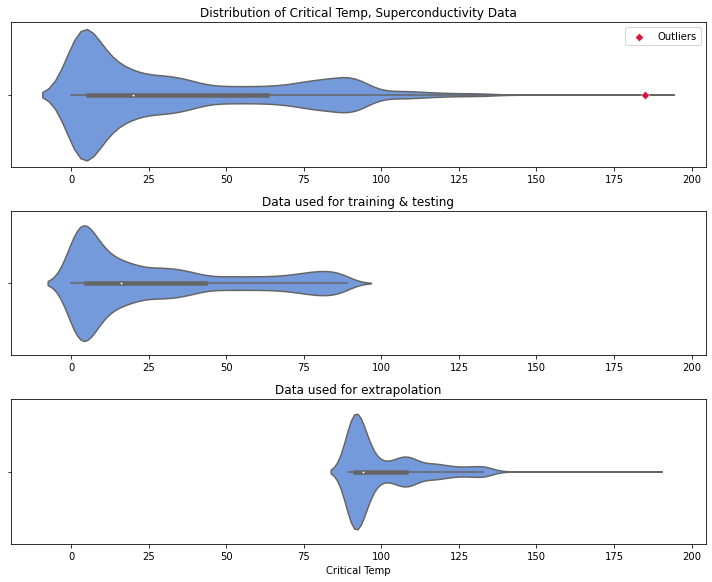

In [24]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex0 = .90
split_percentile_extrap_ex0 = .90


shape_0, mean_is_0, mean_oos_0 = examine_data_regions(df_spr, 'critical_temp', split_percentile_train_test_ex0, split_percentile_extrap_ex0)

print(f'Number of rows >= {split_percentile_extrap_ex0*100} percentile: {shape_0[0]}')
print(f'Mean of target in train/test region: {mean_is_0: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_0: .4f}')

# plot the distributions of the splits
violin_dist_plots_2(df_spr, 
                    'critical_temp', 
                    split_percentile_train_test_ex0, 
                    split_percentile_extrap_ex0, 
                    'Distribution of Critical Temp, Superconductivity Data', 
                    'Critical Temp')

### 2.2 Experiment Split 1 (low)
- train/test: 0-80
- leave out: 81-90
- extrapolate: 91-100

Number of rows >= 91.0 percentile: 1982
Mean of target in train/test region:  20.1917
Mean of target in extrapolation region:  102.2602


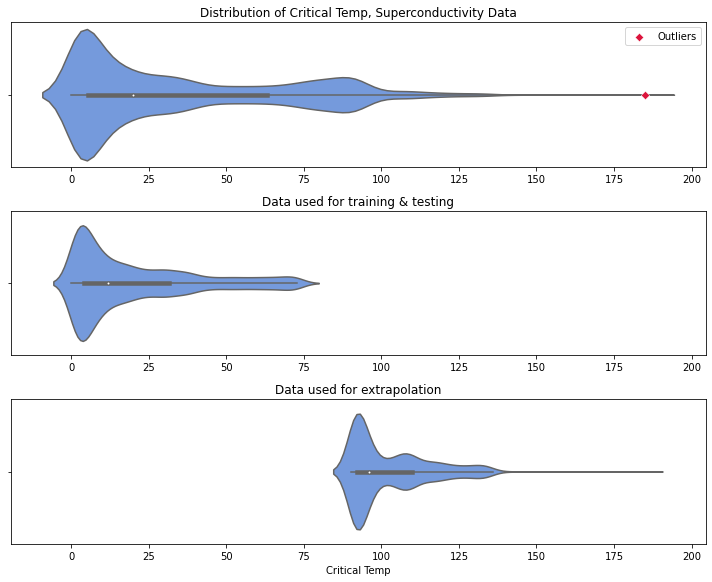

In [25]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex1 = .80
split_percentile_extrap_ex1 = .91


shape_1, mean_is_1, mean_oos_1 = examine_data_regions(df_spr, 'critical_temp', split_percentile_train_test_ex1, split_percentile_extrap_ex1)

print(f'Number of rows >= {split_percentile_extrap_ex1*100} percentile: {shape_1[0]}')
print(f'Mean of target in train/test region: {mean_is_1: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_1: .4f}')

# plot the distributions of the splits
violin_dist_plots_2(df_spr, 
                    'critical_temp', 
                    split_percentile_train_test_ex1, 
                    split_percentile_extrap_ex1, 
                    'Distribution of Critical Temp, Superconductivity Data', 
                    'Critical Temp')

### 2.3 Experiment Split 2 (moderate)
- train/test: [0-70]
- leave out: [71-85]
- extrapolate: [86-100]

Number of rows >= 86.0 percentile: 2976
Mean of target in train/test region:  14.1351
Mean of target in extrapolation region:  96.6657


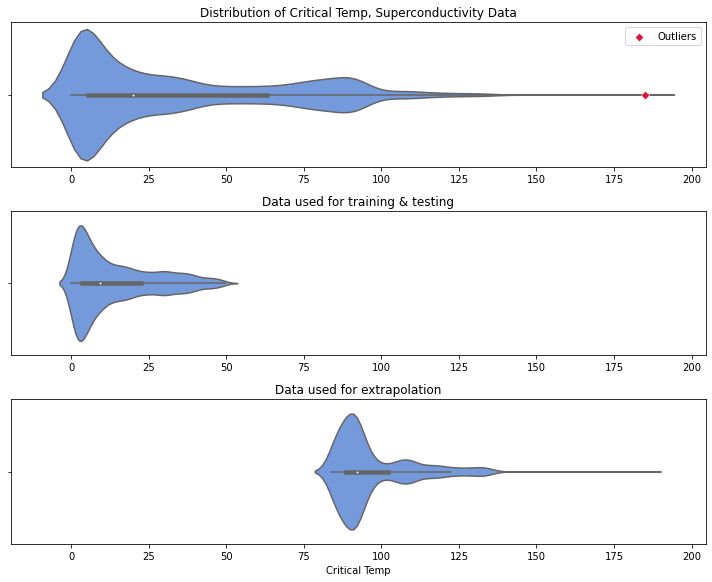

In [26]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex2 = .70
split_percentile_extrap_ex2 = .86

shape_2, mean_is_2, mean_oos_2 = examine_data_regions(df_spr, 'critical_temp', split_percentile_train_test_ex2, split_percentile_extrap_ex2)

print(f'Number of rows >= {split_percentile_extrap_ex2*100} percentile: {shape_2[0]}')
print(f'Mean of target in train/test region: {mean_is_2: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_2: .4f}')

# plot the distributions of the splits
violin_dist_plots_2(df_spr, 
                    'critical_temp', 
                    split_percentile_train_test_ex2, 
                    split_percentile_extrap_ex2, 
                    'Distribution of Critical Temp, Superconductivity Data', 
                    'Critical Temp')

### 2.4 Experiment Split 3 (extreme)
- train/test: 0-60
- leave out: 61-90
- extrapolate: 91-100

Number of rows >= 95.0 percentile: 1100
Mean of target in train/test region:  10.0540
Mean of target in extrapolation region:  110.0862


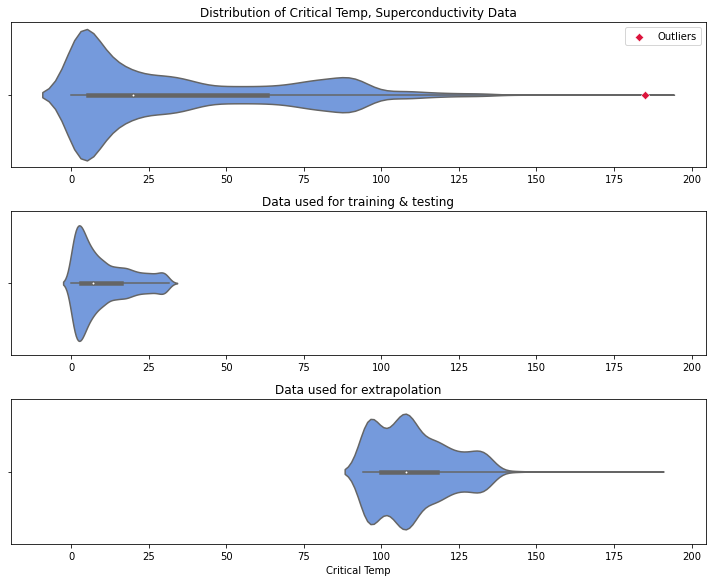

In [27]:
# find a split point in the data for the extrapolation region

split_percentile_train_test_ex3 = .60
split_percentile_extrap_ex3 = .95

shape_3, mean_is_3, mean_oos_3 = examine_data_regions(df_spr, 'critical_temp', split_percentile_train_test_ex3, split_percentile_extrap_ex3)

print(f'Number of rows >= {split_percentile_extrap_ex3*100} percentile: {shape_3[0]}')
print(f'Mean of target in train/test region: {mean_is_3: .4f}')
print(f'Mean of target in extrapolation region: {mean_oos_3: .4f}')

# plot the distributions of the splits
violin_dist_plots_2(df_spr, 
                    'critical_temp', 
                    split_percentile_train_test_ex3, 
                    split_percentile_extrap_ex3, 
                    'Distribution of Critical Temp, Superconductivity Data', 
                    'Critical Temp')

# 3.0 Train/Test/Extrapolation Splits

In [28]:
# standard split

X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0 = train_test_extrapolation_split(df_spr, 'critical_temp', .9, .91)

print(X_train_0.shape)
print(X_test_0.shape)
print(X_extrap_0.shape)

(14355, 81)
(4786, 81)
(1860, 81)


In [29]:
# experiment 1 -- low 
X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1 = train_test_extrapolation_split(df_spr, 'critical_temp', .8, .91)

print(X_train_1.shape)
print(X_test_1.shape)
print(X_extrap_1.shape)

(12755, 81)
(4252, 81)
(1860, 81)


In [30]:
# experiment 2 -- moderate

X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2 = train_test_extrapolation_split(df_spr, 'critical_temp', .7, .86)

print(X_train_2.shape)
print(X_test_2.shape)
print(X_extrap_2.shape)

(11157, 81)
(3720, 81)
(2958, 81)


In [31]:
# experiment 3 -- extreme

X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3 = train_test_extrapolation_split(df_spr, 'critical_temp', .6, .95)

print(X_train_3.shape)
print(X_test_3.shape)
print(X_extrap_3.shape)

(9575, 81)
(3192, 81)
(1054, 81)


# 4.0 Feature Selection

- find uncorrelated columns
- plot heatmap
- then check mutual info

- use the training data from the most extreme split for the most conservative estimate and to minimize potential leakage
- https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

### 4.1 Find the set of uncorrelated columns

In [32]:


corr_matrix = X_train_0.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print('Number of columns to remove: ', len(to_drop))
print('\n')
print(to_drop)

Number of columns to remove:  54


['wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'std_atomic_mass', 'wtd_std_atomic_mass', 'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'std_fie', 'wtd_std_fie', 'wtd_mean_atomic_radius', 'gmean_atomic_radius', 'wtd_gmean_atomic_radius', 'entropy_atomic_radius', 'wtd_entropy_atomic_radius', 'range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius', 'wtd_mean_Density', 'gmean_Density', 'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density', 'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'entropy_ElectronAffinity', 'wtd_entropy_ElectronAffinity', 'std_ElectronAffinity', 'wtd_std_ElectronAffinity', 'wtd_mean_FusionHeat', 'gmean_FusionHeat', 'wtd_gmean_FusionHeat', 'entropy_FusionHeat', 'wtd_entropy_FusionHeat', 'wtd_range_FusionHeat', 'std_FusionHeat', 'wtd_std_FusionHeat', 'wtd_gmean_ThermalConductivity

### Plot the heatmap to visualize this

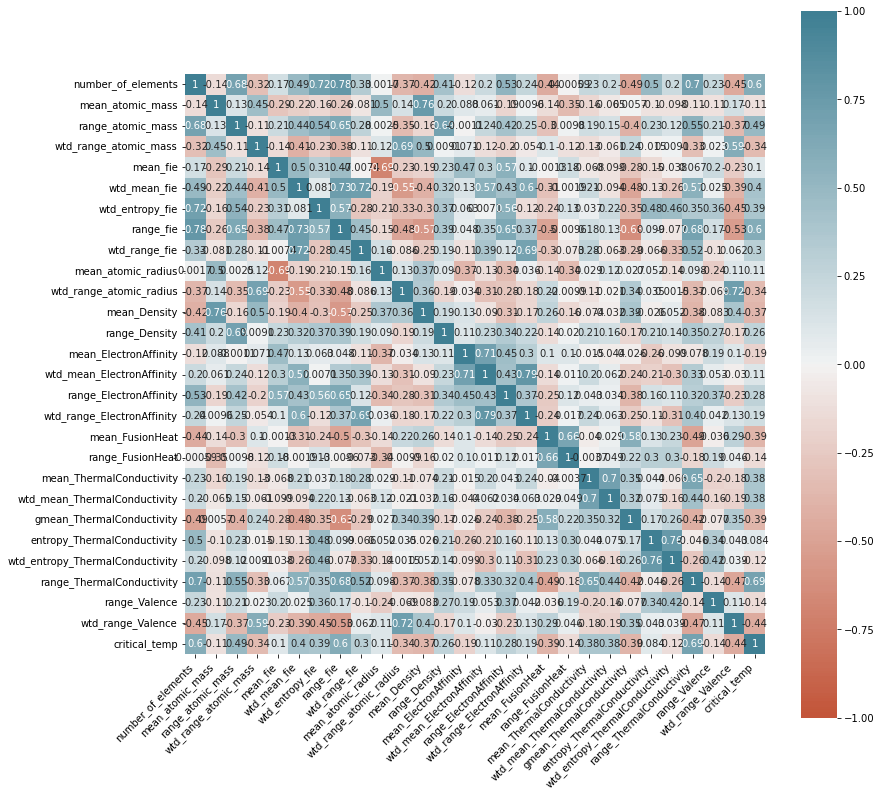

In [33]:
# correlation_heatmap(df_spr, list(selector.get_feature_names_out())+['critical_temp'])

correlation_heatmap(df_spr, [c for c in X_train_0.columns if c not in to_drop]+['critical_temp'])


### 4.2 Check the Mutual Information

In [34]:
mi = mutual_info_regression(X_train_0[[c for c in upper_tri.columns if c not in to_drop]], y_train_0)

mutual_info = pd.DataFrame(index=X_train_0[[c for c in upper_tri.columns if c not in to_drop]].columns, 
                           data={'Mutual_info': mi}).sort_values(by='Mutual_info', ascending=False)

# get some general information about the mutual information
mutual_info.describe()


,Mutual_info
count,27.000000
mean,0.601671
std,0.159073
min,0.107137
25%,0.534490
50%,0.619649
75%,0.715181
max,0.847512


# 5.0 Training, Tuning, Evaluation

In [35]:
# make lists of features for preprocessing

target = ['critical_temp']
features = [c for c in X_train_0.columns if c not in target+to_drop]
cat_feats = [c for c in features if X_train_0[c].dtype==int]
num_feats = [c for c in features if X_train_0[c].dtype==float]

In [36]:
print('Cat feats: ', len(cat_feats), '\n', cat_feats)
print('\n')
print('Num feats: ', len(num_feats), '\n', num_feats)

Cat feats:  2 
 ['number_of_elements', 'range_Valence']


Num feats:  25 
 ['mean_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass', 'mean_fie', 'wtd_mean_fie', 'wtd_entropy_fie', 'range_fie', 'wtd_range_fie', 'mean_atomic_radius', 'wtd_range_atomic_radius', 'mean_Density', 'range_Density', 'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity', 'range_ElectronAffinity', 'wtd_range_ElectronAffinity', 'mean_FusionHeat', 'range_FusionHeat', 'mean_ThermalConductivity', 'wtd_mean_ThermalConductivity', 'gmean_ThermalConductivity', 'entropy_ThermalConductivity', 'wtd_entropy_ThermalConductivity', 'range_ThermalConductivity', 'wtd_range_Valence']


In [37]:
# define a preprocessor
# main task we need is standard scaling the columns, they are almost all numeric

# OHE the range_Valance and number_of_elements (in future iteration, if we want. can mention it in the blog)

def define_preprocessor(cats, nums):
    
    scaler = StandardScaler()
    ohe = OneHotEncoder(sparse=False)

    my_preprocessor = make_column_transformer((scaler, nums), 
                                              (ohe, cats),
                                              remainder='drop')
    
    return my_preprocessor

In [38]:
my_preprocessor = define_preprocessor(cat_feats, num_feats)
my_preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['mean_atomic_mass', 'range_atomic_mass',
                                  'wtd_range_atomic_mass', 'mean_fie',
                                  'wtd_mean_fie', 'wtd_entropy_fie',
                                  'range_fie', 'wtd_range_fie',
                                  'mean_atomic_radius',
                                  'wtd_range_atomic_radius', 'mean_Density',
                                  'range_Density', 'mean_ElectronAffinity',
                                  'wtd_mean_ElectronAffinity',
                                  'range_ElectronAf...
                                  'wtd_range_ElectronAffinity',
                                  'mean_FusionHeat', 'range_FusionHeat',
                                  'mean_ThermalConductivity',
                                  'wtd_mean_ThermalConductivity',
                                  'gmean_ThermalConductivity

### 5.1 Linear Regression Model

In [39]:
# standard case

# define the model
lr_model_0 = LinearRegression()
pipe_lr_0 = make_pipeline(my_preprocessor, lr_model_0)

# fit the model
pipe_lr_0.fit(X_train_0, y_train_0)

# get some eval information
train_rmse_lr_0, test_rmse_lr_0, extrapolation_rmse_lr_0 = evaluations_lr(pipe_lr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)


Linear Regression results on Train/Test
Number of features:  40
Train set RMSE:  17.1093
Test set RMSE:  17.4869


In [40]:
pipe_lr_0.named_steps['linearregression']

LinearRegression()

[  2.03696268   3.20881218  -2.09164799   3.60252668   2.84427211
   3.94738374   1.18004181   1.25140922   4.9410473   -1.22064853
  -6.57354213  -1.65262742  -1.07597213  -2.91266472   1.74103934
  -1.14007468   1.72555549  -2.84962925   0.3786349    4.72410228
  -3.57923891   4.57796838  -1.17059193  10.00380774   3.36945649
  20.79851198   5.47623351  -1.18370084  -4.469145    -4.06345136
  -2.99741229  -6.98135295  -6.57968305   7.12647277   7.69374064
   2.13038994   1.45047306  -1.85926552  -4.67305478 -11.86875611]


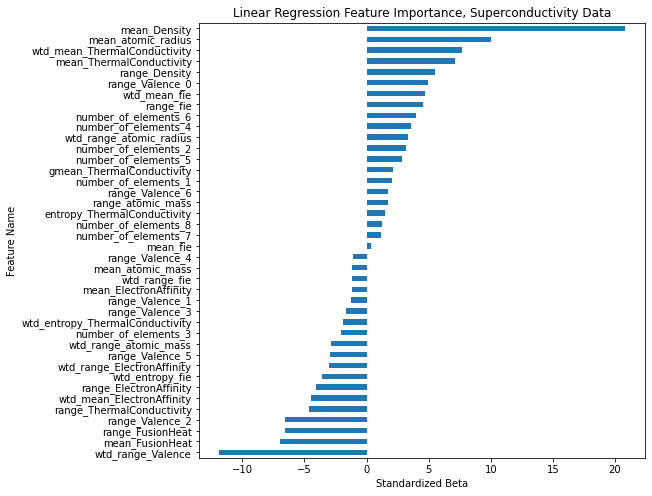

In [41]:
# get feature importances
# standard case

print(pipe_lr_0.named_steps['linearregression'].coef_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_0[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(pipe_lr_0.named_steps['linearregression'].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Superconductivity Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


In [42]:
# first case

# define the model
lr_model_1 = LinearRegression()
pipe_lr_1 = make_pipeline(my_preprocessor, lr_model_1)

# fit the model
pipe_lr_1.fit(X_train_1, y_train_1)

# get some eval information
# train_rmse_lr_1, test_rmse_lr_1 = evaluations_lr(best_model_lr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_lr_1, test_rmse_lr_1, extrapolation_rmse_lr_1 = evaluations_lr(pipe_lr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)


Linear Regression results on Train/Test
Number of features:  40
Train set RMSE:  13.2825
Test set RMSE:  13.3596


[ 1.33129758  1.11983718 -1.723344    2.63855903  1.81931878  2.91858172
  1.97259985  0.72874553  2.91525609 -0.77599689 -4.53299871 -0.95309863
 -0.78942262 -2.83426912  1.01623501 -0.44521197  1.38405189 -1.9671723
 -1.6696564   2.93858593 -1.10359597  3.60743028 -1.17046232  9.64547474
  2.52873804 13.93723491  1.26670948 -3.14888269 -5.23406471 -5.38903161
 -1.95307724 -3.19150694  3.7126188   2.6279214   4.10092502  0.5514557
 -0.62076383 -0.87559693 -2.98596911 -2.79797226]


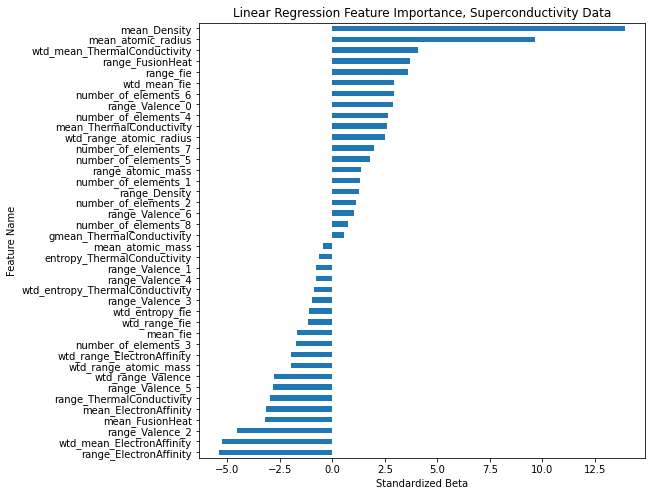

In [43]:
# get feature importances
# first case

print(pipe_lr_1.named_steps['linearregression'].coef_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_1[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(pipe_lr_1.named_steps['linearregression'].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Superconductivity Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


In [44]:
# second case

# define the model
lr_model_2 = LinearRegression()
pipe_lr_2 = make_pipeline(my_preprocessor, lr_model_2)

# fit the model
pipe_lr_2.fit(X_train_2, y_train_2)

# get some eval information
# train_rmse_lr_2, test_rmse_lr_2 = evaluations_lr(best_model_lr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_lr_2, test_rmse_lr_2, extrapolation_rmse_lr_2 = evaluations_lr(pipe_lr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)



Linear Regression results on Train/Test
Number of features:  40
Train set RMSE:  9.0776
Test set RMSE:  9.0074


[ 0.8710287  -0.50688267 -1.29434423 -0.424524    2.75324092  2.36065343
  2.83057878  0.0642473   0.30247658 -0.39593812 -2.61114968 -0.38751486
  0.73377294 -4.41091599  0.49788084  0.69420106  1.2359324  -1.12881091
 -3.36735836  0.75779736  1.94329728  1.70707992 -0.69455157  8.13636216
  2.03082663  9.55629055  0.67831463 -1.18430312 -1.8937873  -3.60066047
 -1.44982131 -0.29473626 -1.81129673  1.46208251  3.0533974   0.02936149
 -1.309843    1.10477759 -1.34697684 -2.99279915]


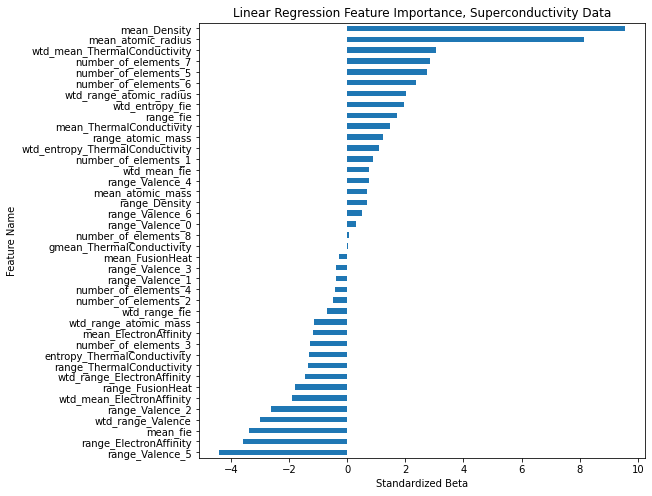

In [45]:
# get feature importances
# second case

print(pipe_lr_2.named_steps['linearregression'].coef_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_2[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(pipe_lr_2.named_steps['linearregression'].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Superconductivity Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


In [46]:
# third case

# define the model
lr_model_3 = LinearRegression()
pipe_lr_3 = make_pipeline(my_preprocessor, lr_model_3)

# fit the model
pipe_lr_3.fit(X_train_3, y_train_3)

# get some eval information
# train_rmse_lr_3, test_rmse_lr_3 = evaluations_lr(best_model_lr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_lr_3, test_rmse_lr_3, extrapolation_rmse_lr_3 = evaluations_lr(pipe_lr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)



Linear Regression results on Train/Test
Number of features:  40
Train set RMSE:  6.3924
Test set RMSE:  6.3359


[ 0.35007599 -0.02262906 -1.08640792 -2.22852832  3.5373729   1.81309693
  2.85905445 -0.8457448  -0.09826479  1.40463328 -1.23071993 -0.48799411
  1.17953032 -3.10921423  0.19902917  0.92222354  0.96086231 -0.68062796
 -2.6618743  -0.39737153  2.10359941  0.97914732 -0.4359406   5.02799045
  0.97028514  8.24280232  0.3594001  -1.36584231 -1.28723332 -2.99152521
 -1.26119417 -1.22037087 -0.47603653  0.39418669  1.66964444  0.33960913
 -0.31137563  1.62532957 -2.44306261 -1.27433158]


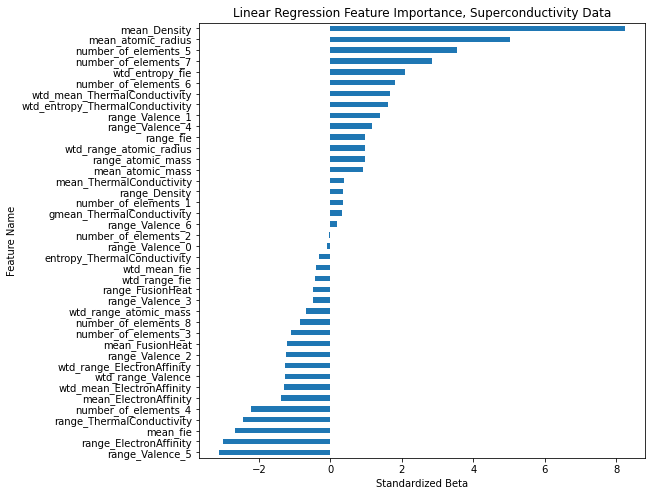

In [47]:
# get feature importances
# third case

print(pipe_lr_3.named_steps['linearregression'].coef_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_3[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(pipe_lr_3.named_steps['linearregression'].coef_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Linear Regression Feature Importance, Superconductivity Data')
plt.xlabel('Standardized Beta')
plt.ylabel('Feature Name')
plt.show()


### 5.2 Random Forest Model

In [48]:
# define the model

rfr_model = RandomForestRegressor(criterion='squared_error', random_state=12)
pipe_rfr = make_pipeline(my_preprocessor, rfr_model)

kfold = KFold(n_splits=3, shuffle=True, random_state=12)


In [49]:
# standard case

# build the folds for cross validation
cv_generator = kfold.split(X_train_0, y_train_0)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(60, 140, 3)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(5,14,4)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(4,10,3)).astype(int)}

param_grid = {'randomforestregressor__n_estimators':[100],
              'randomforestregressor__max_depth':[14], 
              'randomforestregressor__min_samples_leaf':[4]}



grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=2, return_train_score=True)

grid_rfr.fit(X_train_0, y_train_0)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_0 = grid_rfr.best_estimator_

train_rmse_rfr_0, test_rmse_rfr_0, extrapolation_rmse_rfr_0 = evaluations_rfr(best_model_rfr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END randomforestregressor__max_depth=14, randomforestregressor__min_samples_leaf=4, randomforestregressor__n_estimators=100; total time=  18.4s
[CV] END randomforestregressor__max_depth=14, randomforestregressor__min_samples_leaf=4, randomforestregressor__n_estimators=100; total time=  16.6s
[CV] END randomforestregressor__max_depth=14, randomforestregressor__min_samples_leaf=4, randomforestregressor__n_estimators=100; total time=  18.5s
Best cross-validation score: 0.8691
Best parameters: {'randomforestregressor__max_depth': 14, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__n_estimators': 100}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=14, min_samples_leaf=4, random_state=12)
Train set RMSE:  7.3337
Test set RMSE:  9.4602


[6.77736944e-03 9.23868255e-03 1.73383918e-02 6.70033507e-03
 1.82007672e-02 1.24671922e-02 5.58651579e-03 1.57737387e-02
 9.58726585e-03 1.07849763e-02 3.01925425e-02 2.27885145e-03
 7.08576988e-03 2.19529759e-02 4.92944978e-03 8.87885234e-02
 1.04475716e-02 4.72110050e-03 1.00664144e-02 7.03640449e-02
 2.76148225e-03 1.37378605e-02 1.51468354e-02 5.73499945e-01
 2.66317537e-02 2.02373545e-07 7.21718294e-06 6.22223237e-05
 3.42331175e-04 3.31728724e-04 4.40199956e-04 8.98672242e-05
 0.00000000e+00 4.33619120e-05 2.24836517e-03 7.04149880e-04
 1.65138040e-04 2.12734972e-04 2.92124798e-04 0.00000000e+00]


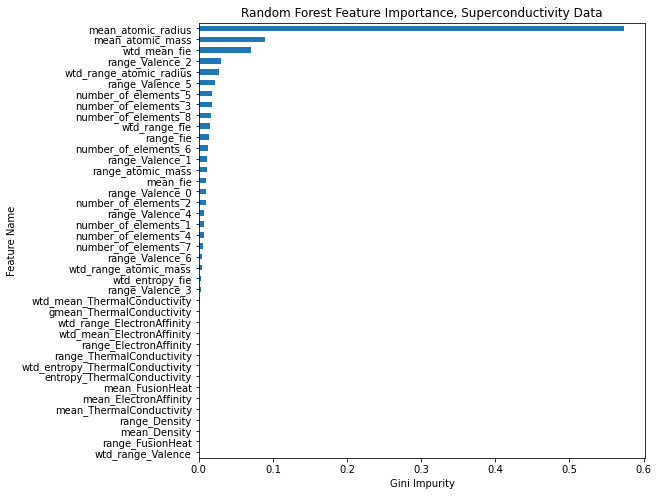

In [50]:
# get feature importances
# standard case

print(best_model_rfr_0.named_steps['randomforestregressor'].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_0[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(best_model_rfr_0.named_steps['randomforestregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Superconductivity Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [51]:
# first case

# build the folds for cross validation
cv_generator = kfold.split(X_train_1, y_train_1)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(60, 140, 3)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(5,14,4)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(4,10,3)).astype(int)}

param_grid = {'randomforestregressor__n_estimators':[140],
              'randomforestregressor__max_depth':[14], 
              'randomforestregressor__min_samples_leaf':[4]}


grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=2, return_train_score=True)

grid_rfr.fit(X_train_1, y_train_1)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_1 = grid_rfr.best_estimator_

# train_rmse_rfr_1, test_rmse_rfr_1 = evaluations_rfr(best_model_rfr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_rfr_1, test_rmse_rfr_1, extrapolation_rmse_rfr_1 = evaluations_rfr(best_model_rfr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END randomforestregressor__max_depth=14, randomforestregressor__min_samples_leaf=4, randomforestregressor__n_estimators=140; total time=  13.5s
[CV] END randomforestregressor__max_depth=14, randomforestregressor__min_samples_leaf=4, randomforestregressor__n_estimators=140; total time=  17.0s
[CV] END randomforestregressor__max_depth=14, randomforestregressor__min_samples_leaf=4, randomforestregressor__n_estimators=140; total time=  18.5s
Best cross-validation score: 0.8366
Best parameters: {'randomforestregressor__max_depth': 14, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__n_estimators': 140}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=14, min_samples_leaf=4, n_estimators=140,
                      random_state=12)
Train set RMSE:  5.7453
Test set RMSE:  8.0291


[9.29795541e-03 6.85808955e-03 1.88531582e-02 8.15870416e-03
 2.08759619e-02 1.53833457e-02 8.66155009e-03 1.52131858e-02
 9.72910716e-03 1.46361949e-02 4.39747051e-02 6.63816166e-03
 1.67610079e-02 2.18256574e-02 6.44642169e-03 7.13329847e-02
 1.03633637e-02 6.28791383e-03 8.67915941e-03 6.70076066e-02
 3.44723962e-03 2.67162586e-02 1.65345190e-02 5.30650349e-01
 2.94329723e-02 1.10753011e-06 2.89519106e-05 7.60944927e-05
 3.73844738e-04 4.66807051e-04 3.84566784e-04 7.19647232e-05
 0.00000000e+00 1.65766210e-04 2.34395378e-03 7.96013679e-04
 3.23057061e-04 1.43074517e-04 1.05922455e-03 0.00000000e+00]


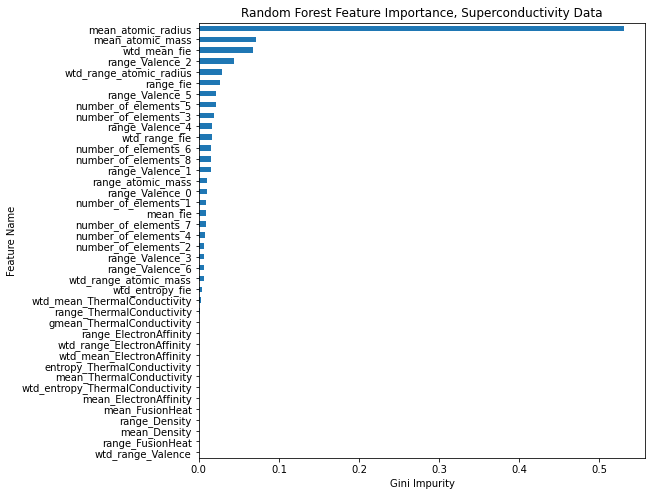

In [52]:
# get feature importances
# first case

print(best_model_rfr_1.named_steps['randomforestregressor'].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_1[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(best_model_rfr_1.named_steps['randomforestregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Superconductivity Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [53]:
# second case

# build the folds for cross validation
cv_generator = kfold.split(X_train_2, y_train_2)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(75, 90, 3)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(6,10,3)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(10,13,2)).astype(int)}

param_grid = {'randomforestregressor__n_estimators':[90],
              'randomforestregressor__max_depth':[10], 
              'randomforestregressor__min_samples_leaf':[10]}

grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=2, return_train_score=True)

grid_rfr.fit(X_train_2, y_train_2)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")
print('\n')
best_model_rfr_2 = grid_rfr.best_estimator_

# train_rmse_rfr_2, test_rmse_rfr_2 = evaluations_rfr(best_model_rfr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_rfr_2, test_rmse_rfr_2, extrapolation_rmse_rfr_2 = evaluations_rfr(best_model_rfr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=10, randomforestregressor__n_estimators=90; total time=   6.8s
[CV] END randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=10, randomforestregressor__n_estimators=90; total time=  10.9s
[CV] END randomforestregressor__max_depth=10, randomforestregressor__min_samples_leaf=10, randomforestregressor__n_estimators=90; total time=  10.2s
Best cross-validation score: 0.7605
Best parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 10, 'randomforestregressor__n_estimators': 90}


Random Forest results on Train/Test
RandomForestRegressor(max_depth=10, min_samples_leaf=10, n_estimators=90,
                      random_state=12)
Train set RMSE:  5.4180
Test set RMSE:  6.1201


[1.04738509e-02 7.94073556e-03 2.88848532e-02 8.43062860e-03
 2.80060212e-02 1.58353537e-02 1.18707870e-02 1.15615482e-02
 1.05313673e-02 1.28135700e-02 1.07675585e-01 7.40583101e-03
 1.33546717e-02 2.29863858e-02 7.42141265e-03 4.64421522e-02
 1.15073786e-02 2.26831732e-02 8.85384333e-03 2.35222210e-02
 3.39948717e-03 3.10247054e-02 2.07581521e-02 4.95455281e-01
 2.52991801e-02 0.00000000e+00 4.47403589e-05 2.32084155e-04
 3.83403004e-04 1.01449745e-03 2.38010208e-04 8.58912827e-05
 0.00000000e+00 1.98440981e-04 1.44225637e-03 7.17248027e-04
 5.95394432e-04 2.73414391e-04 6.36443167e-04 0.00000000e+00]


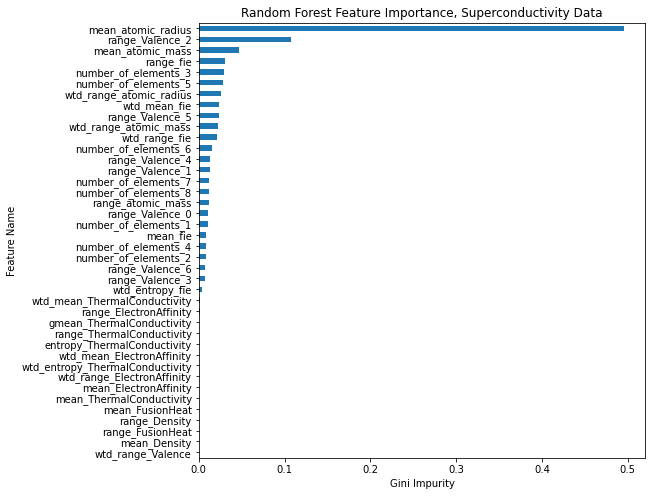

In [54]:
# get feature importances
# second case

print(best_model_rfr_2.named_steps['randomforestregressor'].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_2[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(best_model_rfr_2.named_steps['randomforestregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Superconductivity Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



In [55]:
# third case

# build the folds for cross validation
cv_generator = kfold.split(X_train_3, y_train_3)


# param_grid = {'randomforestregressor__n_estimators':np.round(np.linspace(70, 120, 5)).astype(int),
#               'randomforestregressor__max_depth':np.round(np.linspace(6,12,3)).astype(int), 
#               'randomforestregressor__min_samples_leaf':np.round(np.linspace(7,10,2)).astype(int)}

param_grid = {'randomforestregressor__n_estimators':[108],
              'randomforestregressor__max_depth':[12], 
              'randomforestregressor__min_samples_leaf':[7]}

grid_rfr = GridSearchCV(pipe_rfr, param_grid, cv=cv_generator, verbose=2, return_train_score=True)

grid_rfr.fit(X_train_3, y_train_3)

print(f"Best cross-validation score: {grid_rfr.best_score_:.4f}")
print(f"Best parameters: {grid_rfr.best_params_}")

best_model_rfr_3 = grid_rfr.best_estimator_

# train_rmse_rfr_3, test_rmse_rfr_3 = evaluations_rfr(best_model_rfr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_rfr_3, test_rmse_rfr_3, extrapolation_rmse_rfr_3 = evaluations_rfr(best_model_rfr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END randomforestregressor__max_depth=12, randomforestregressor__min_samples_leaf=7, randomforestregressor__n_estimators=108; total time=  11.4s
[CV] END randomforestregressor__max_depth=12, randomforestregressor__min_samples_leaf=7, randomforestregressor__n_estimators=108; total time=  13.4s
[CV] END randomforestregressor__max_depth=12, randomforestregressor__min_samples_leaf=7, randomforestregressor__n_estimators=108; total time=   7.3s
Best cross-validation score: 0.7519
Best parameters: {'randomforestregressor__max_depth': 12, 'randomforestregressor__min_samples_leaf': 7, 'randomforestregressor__n_estimators': 108}
Random Forest results on Train/Test
RandomForestRegressor(max_depth=12, min_samples_leaf=7, n_estimators=108,
                      random_state=12)
Train set RMSE:  3.3399
Test set RMSE:  3.9837


[2.19471798e-02 8.75794315e-03 2.29070972e-02 1.24250947e-02
 2.72760934e-02 2.43498767e-02 2.13272433e-01 1.26903453e-02
 1.13376083e-02 2.45024594e-02 6.45184485e-02 1.07763057e-02
 7.80174511e-03 3.19448297e-02 2.26659144e-02 1.43091290e-02
 1.73844213e-02 2.68208549e-02 1.34368864e-02 4.32804827e-02
 9.16416029e-03 2.30678792e-02 4.57934485e-02 2.63160861e-01
 1.53157009e-02 0.00000000e+00 1.06732611e-04 1.97297322e-04
 7.75715251e-04 1.14802302e-03 2.31995199e-04 2.31945566e-05
 0.00000000e+00 1.83562877e-03 7.61684801e-04 5.85826980e-04
 7.55191185e-04 2.23397735e-03 2.43753494e-03 0.00000000e+00]


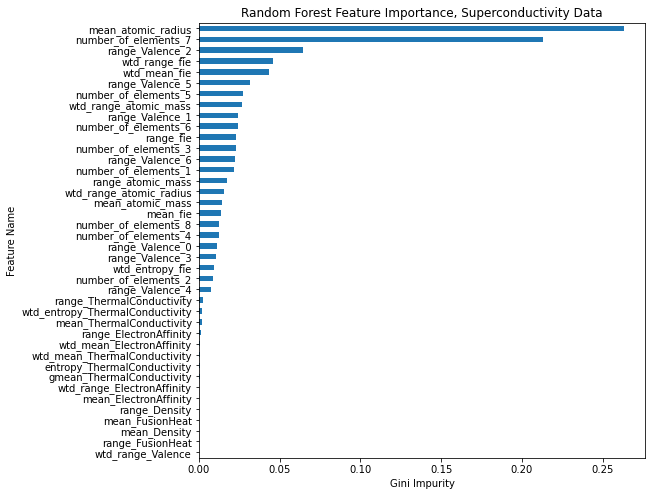

In [56]:
# get feature importances
# third case

print(best_model_rfr_3.named_steps['randomforestregressor'].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_3[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(best_model_rfr_3.named_steps['randomforestregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Random Forest Feature Importance, Superconductivity Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()



### 5.3 Decision Tree Model

In [57]:
# define the model

dtr_model = DecisionTreeRegressor(criterion='squared_error', random_state=12)
pipe_dtr = make_pipeline(my_preprocessor, dtr_model)

kfold = KFold(n_splits=5, shuffle=True, random_state=12)


In [58]:
# standard case

# build the folds for cross validation
cv_generator = kfold.split(X_train_0, y_train_0)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(10,12,3)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(15,20,4)).astype(int)}

param_grid = {'decisiontreeregressor__max_depth':[12], 
              'decisiontreeregressor__min_samples_leaf':[15]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_0, y_train_0)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_0 = grid_dtr.best_estimator_

# train_rmse_dtr_0, test_rmse_dtr_0 = evaluations_dtr(best_model_dtr_0, X_train_0, y_train_0, X_test_0, y_test_0)
train_rmse_dtr_0, test_rmse_dtr_0, extrapolation_rmse_dtr_0 = evaluations_dtr(best_model_dtr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.8100


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=12, min_samples_leaf=15, random_state=12)
Train set RMSE:  10.4824
Test set RMSE:  11.9402


[6.00451030e-03 3.92824600e-03 1.56173684e-02 6.33473153e-03
 1.52008267e-02 3.93757123e-03 1.31431855e-03 1.17883611e-02
 1.28040875e-02 1.45879927e-02 2.69609723e-02 2.69425012e-03
 6.20057731e-03 1.73924908e-02 3.26287554e-03 1.31610827e-01
 9.42052846e-03 3.44442858e-03 1.20787351e-02 3.22048921e-02
 2.55837384e-03 1.38301863e-02 7.99133981e-03 6.13581843e-01
 1.91110595e-02 0.00000000e+00 0.00000000e+00 3.88700422e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.82534705e-03 0.00000000e+00
 0.00000000e+00 1.27438856e-03 0.00000000e+00 0.00000000e+00]


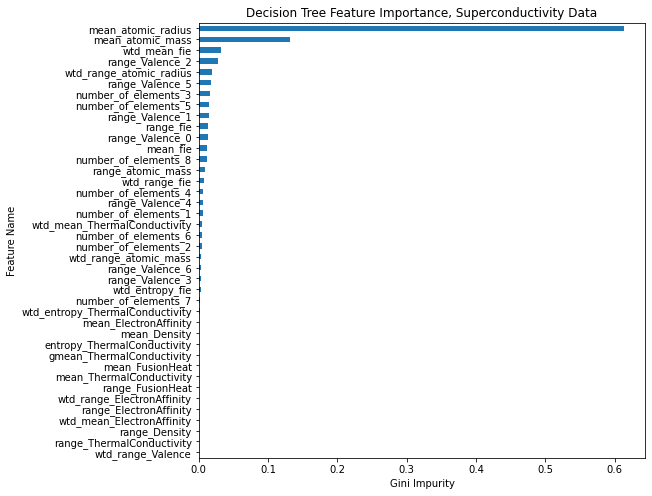

In [59]:
# get feature importances
# standard case

print(best_model_dtr_0.named_steps['decisiontreeregressor'].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_0[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(best_model_dtr_0.named_steps['decisiontreeregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Superconductivity Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


In [60]:
# first case

# build the folds for cross validation
cv_generator = kfold.split(X_train_1, y_train_1)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(7,10,3)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(17,20,4)).astype(int)}

param_grid = {'decisiontreeregressor__max_depth':[10], 
              'decisiontreeregressor__min_samples_leaf':[17]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_1, y_train_1)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_1 = grid_dtr.best_estimator_

# train_rmse_dtr_1, test_rmse_dtr_1 = evaluations_dtr(best_model_dtr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_dtr_1, test_rmse_dtr_1, extrapolation_rmse_dtr_1 = evaluations_dtr(best_model_dtr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.7619


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=10, min_samples_leaf=17, random_state=12)
Train set RMSE:  8.5809
Test set RMSE:  10.0025


[7.00529211e-03 5.03573646e-03 1.10984753e-02 3.59621161e-03
 4.99690532e-03 8.82318454e-03 2.87745744e-03 9.12175177e-03
 7.86408799e-03 1.12035458e-02 4.39419488e-02 2.14003966e-02
 1.00203291e-02 1.17015864e-02 8.04544865e-03 2.29983959e-02
 1.25047174e-02 4.18649882e-03 1.63897942e-03 1.09958311e-01
 1.98726645e-03 3.67962960e-02 7.51506595e-03 5.86612439e-01
 4.55044589e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.38666487e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.22654679e-03 0.00000000e+00]


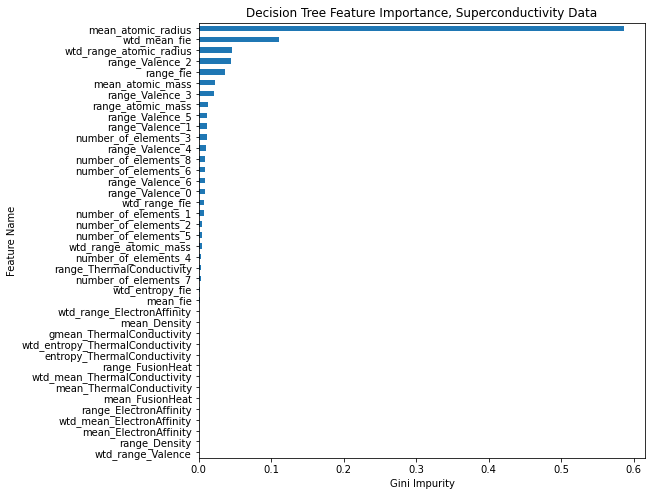

In [61]:
# get feature importances
# first case

print(best_model_dtr_1.named_steps['decisiontreeregressor'].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_1[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(best_model_dtr_1.named_steps['decisiontreeregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Superconductivity Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


In [62]:
# second case

# build the folds for cross validation
cv_generator = kfold.split(X_train_2, y_train_2)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(7,10,3)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(20,22,3)).astype(int)}

param_grid = {'decisiontreeregressor__max_depth':[10], 
              'decisiontreeregressor__min_samples_leaf':[20]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_2, y_train_2)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_2 = grid_dtr.best_estimator_

# train_rmse_dtr_2, test_rmse_dtr_2 = evaluations_dtr(best_model_dtr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_dtr_2, test_rmse_dtr_2, extrapolation_rmse_dtr_2 = evaluations_dtr(best_model_dtr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.6988


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=10, min_samples_leaf=20, random_state=12)
Train set RMSE:  6.1219
Test set RMSE:  6.8977


[8.51908278e-03 7.63068549e-03 4.81549527e-02 4.22012928e-03
 2.40857954e-02 1.41584450e-02 4.01982309e-03 5.39809579e-03
 3.21125760e-03 5.03624125e-03 1.01845687e-01 9.56556982e-03
 1.60956988e-02 1.67701757e-02 4.73346166e-03 5.32241627e-02
 7.68117673e-03 4.53715892e-02 1.12745067e-02 2.06228624e-02
 1.72470836e-03 2.29498311e-02 2.17807050e-02 5.17923890e-01
 2.06812830e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.20306955e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.63355186e-03 0.00000000e+00
 4.83561997e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]


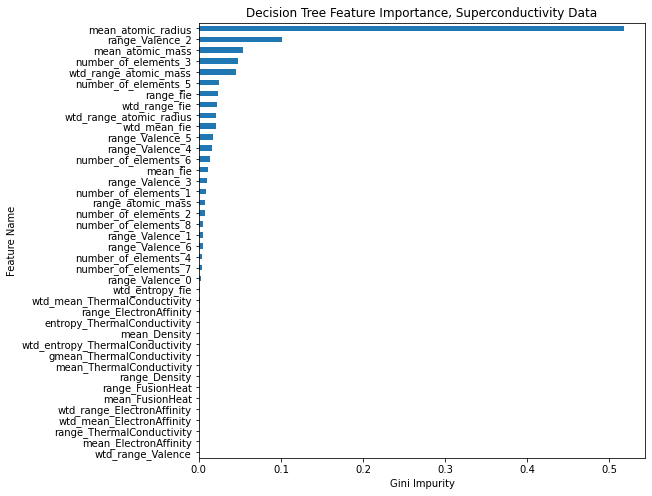

In [63]:
# get feature importances
# second case

print(best_model_dtr_2.named_steps['decisiontreeregressor'].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_2[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(best_model_dtr_2.named_steps['decisiontreeregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Superconductivity Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


In [64]:
# third case

# build the folds for cross validation
cv_generator = kfold.split(X_train_3, y_train_3)


# param_grid = {'decisiontreeregressor__max_depth':np.round(np.linspace(8,10,2)).astype(int), 
#               'decisiontreeregressor__min_samples_leaf':np.round(np.linspace(13,20,4)).astype(int)}

param_grid = {'decisiontreeregressor__max_depth':[10], 
              'decisiontreeregressor__min_samples_leaf':[13]}


grid_dtr = GridSearchCV(pipe_dtr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_dtr.fit(X_train_3, y_train_3)

print(f"Best cross-validation score: {grid_dtr.best_score_:.4f}")
# print(f"Best parameters: {grid_dt.best_params_}")
print('\n')
best_model_dtr_3 = grid_dtr.best_estimator_

# train_rmse_dtr_3, test_rmse_dtr_3 = evaluations_dtr(best_model_dtr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_dtr_3, test_rmse_dtr_3, extrapolation_rmse_dtr_3 = evaluations_dtr(best_model_dtr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.6683


Decision Tree results on Train/Test
DecisionTreeRegressor(max_depth=10, min_samples_leaf=13, random_state=12)
Train set RMSE:  4.2552
Test set RMSE:  4.7639


[1.63295980e-02 5.60871607e-03 2.25919472e-02 9.24819916e-03
 1.48565608e-02 3.64413855e-02 1.25510180e-01 5.73688173e-03
 6.20033004e-03 1.52234463e-02 4.72154945e-02 1.03051895e-02
 6.13318082e-03 1.55086199e-02 2.20659899e-02 1.09606929e-02
 5.44714003e-03 4.65697116e-02 7.74623101e-03 2.67666092e-02
 3.35638154e-02 1.17397426e-02 4.68407278e-02 4.35892499e-01
 1.05229424e-02 0.00000000e+00 1.59695189e-04 2.71484522e-04
 8.66006189e-04 2.02738576e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.64959707e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


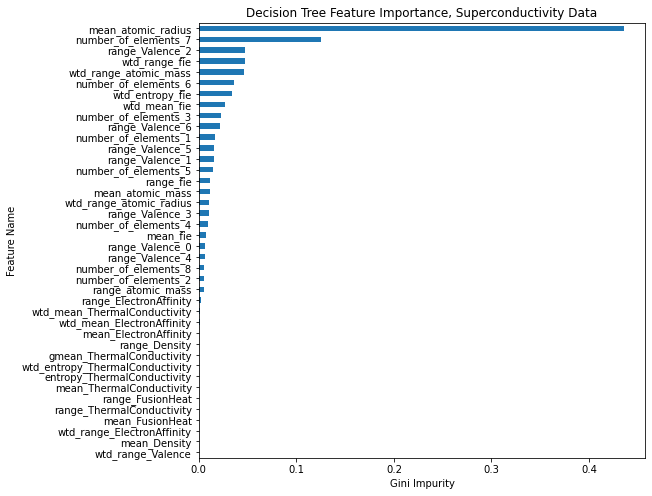

In [65]:
# get feature importances
# third case

print(best_model_dtr_3.named_steps['decisiontreeregressor'].feature_importances_)

feature_names = my_preprocessor.transformers[1][1].fit(X_train_3[cat_feats]).get_feature_names_out(cat_feats).tolist() + num_feats

pd.Series(best_model_dtr_3.named_steps['decisiontreeregressor'].feature_importances_, index=feature_names).sort_values().plot(kind='barh', figsize=(8,8))
plt.title('Decision Tree Feature Importance, Superconductivity Data')
plt.xlabel('Gini Impurity')
plt.ylabel('Feature Name')
plt.show()


### 5.4 Gradient Boosting Regressor

In [66]:
# define the model

hgbr_model = HistGradientBoostingRegressor(loss='squared_error', random_state=12)
pipe_hgbr = make_pipeline(my_preprocessor, hgbr_model)

kfold = KFold(n_splits=3, shuffle=True, random_state=12)

In [67]:
# standard case

# build the folds for cross validation
cv_generator = kfold.split(X_train_0, y_train_0)


# param_grid = {'histgradientboostingregressor__learning_rate': np.linspace(.065, .08, 5), 
#               'histgradientboostingregressor__max_iter': np.linspace(95, 120, 4).astype(int),
#               'histgradientboostingregressor__min_samples_leaf': np.round(np.linspace(20, 30, 3)).astype(int)}

param_grid = {'histgradientboostingregressor__learning_rate': [0.08], 
              'histgradientboostingregressor__max_iter':[120],
              'histgradientboostingregressor__min_samples_leaf':[25]}



grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_0, y_train_0)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_0 = grid_hgbr.best_estimator_


# train_rmse_hgbr_0, test_rmse_hgbr_0 = evaluations_hgbr(best_model_hgbr_0, X_train_0, y_train_0, X_test_0, y_test_0)
train_rmse_hgbr_0, test_rmse_hgbr_0, extrapolation_rmse_hgbr_0 = evaluations_hgbr(best_model_hgbr_0, X_train_0, y_train_0, X_test_0, y_test_0, X_extrap_0, y_extrap_0)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.8633
Best parameters: {'histgradientboostingregressor__learning_rate': 0.08, 'histgradientboostingregressor__max_iter': 120, 'histgradientboostingregressor__min_samples_leaf': 25}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.08, max_iter=120,
                              min_samples_leaf=25, random_state=12)
Train set RMSE:  8.4060
Test set RMSE:  9.7682


In [68]:
# first case

# build the folds for cross validation
cv_generator = kfold.split(X_train_1, y_train_1)


# param_grid = {'histgradientboostingregressor__learning_rate': np.linspace(.05, .065, 4), 
#               'histgradientboostingregressor__max_iter': np.linspace(95, 115, 5).astype(int),
#               'histgradientboostingregressor__min_samples_leaf': np.round(np.linspace(24, 30, 3)).astype(int)}

param_grid = {'histgradientboostingregressor__learning_rate': [0.065], 
              'histgradientboostingregressor__max_iter':[115],
              'histgradientboostingregressor__min_samples_leaf':[24]}



grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_1, y_train_1)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_1 = grid_hgbr.best_estimator_


# train_rmse_hgbr_1, test_rmse_hgbr_1 = evaluations_hgbr(best_model_hgbr_1, X_train_1, y_train_1, X_test_1, y_test_1)
train_rmse_hgbr_1, test_rmse_hgbr_1, extrapolation_rmse_hgbr_1 = evaluations_hgbr(best_model_hgbr_1, X_train_1, y_train_1, X_test_1, y_test_1, X_extrap_1, y_extrap_1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.8224
Best parameters: {'histgradientboostingregressor__learning_rate': 0.065, 'histgradientboostingregressor__max_iter': 115, 'histgradientboostingregressor__min_samples_leaf': 24}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.065, max_iter=115,
                              min_samples_leaf=24, random_state=12)
Train set RMSE:  7.4069
Test set RMSE:  8.6382


In [69]:
# second case

# build the folds for cross validation
cv_generator = kfold.split(X_train_2, y_train_2)


# param_grid = {'histgradientboostingregressor__learning_rate': np.linspace(.06, .075, 4), 
#               'histgradientboostingregressor__max_iter': np.linspace(90, 125, 5).astype(int),
#               'histgradientboostingregressor__min_samples_leaf': np.round(np.linspace(24, 30, 3)).astype(int)}

param_grid = {'histgradientboostingregressor__learning_rate': [0.075], 
              'histgradientboostingregressor__max_iter':[125],
              'histgradientboostingregressor__min_samples_leaf':[24]}



grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_2, y_train_2)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_2 = grid_hgbr.best_estimator_


# train_rmse_hgbr_2, test_rmse_hgbr_2 = evaluations_hgbr(best_model_hgbr_2, X_train_2, y_train_2, X_test_2, y_test_2)
train_rmse_hgbr_2, test_rmse_hgbr_2, extrapolation_rmse_hgbr_2 = evaluations_hgbr(best_model_hgbr_2, X_train_2, y_train_2, X_test_2, y_test_2, X_extrap_2, y_extrap_2)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.7778
Best parameters: {'histgradientboostingregressor__learning_rate': 0.075, 'histgradientboostingregressor__max_iter': 125, 'histgradientboostingregressor__min_samples_leaf': 24}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.075, max_iter=125,
                              min_samples_leaf=24, random_state=12)
Train set RMSE:  5.1545
Test set RMSE:  5.8706


In [70]:
# third case

# build the folds for CV
cv_generator = kfold.split(X_train_3, y_train_3)


# param_grid = {'histgradientboostingregressor__learning_rate': np.linspace(.06, .08, 3), 
#               'histgradientboostingregressor__max_iter': np.linspace(80, 110, 3).astype(int),
#               'histgradientboostingregressor__min_samples_leaf': np.round(np.linspace(24, 30, 3)).astype(int)}

param_grid = {'histgradientboostingregressor__learning_rate': [0.08], 
              'histgradientboostingregressor__max_iter':[110],
              'histgradientboostingregressor__min_samples_leaf':[27]}



grid_hgbr = GridSearchCV(pipe_hgbr, param_grid, cv=cv_generator, verbose=1, return_train_score=True)

grid_hgbr.fit(X_train_3, y_train_3)

print(f"Best cross-validation score: {grid_hgbr.best_score_:.4f}")
print(f"Best parameters: {grid_hgbr.best_params_}")

best_model_hgbr_3 = grid_hgbr.best_estimator_


# train_rmse_hgbr_3, test_rmse_hgbr_3 = evaluations_hgbr(best_model_hgbr_3, X_train_3, y_train_3, X_test_3, y_test_3)
train_rmse_hgbr_3, test_rmse_hgbr_3, extrapolation_rmse_hgbr_3 = evaluations_hgbr(best_model_hgbr_3, X_train_3, y_train_3, X_test_3, y_test_3, X_extrap_3, y_extrap_3)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best cross-validation score: 0.7505
Best parameters: {'histgradientboostingregressor__learning_rate': 0.08, 'histgradientboostingregressor__max_iter': 110, 'histgradientboostingregressor__min_samples_leaf': 27}
Hist Grad Booster results on Train/Test
HistGradientBoostingRegressor(learning_rate=0.08, max_iter=110,
                              min_samples_leaf=27, random_state=12)
Train set RMSE:  3.6216
Test set RMSE:  4.1654


# 6.0 Save RMSE Values for Plotting
- Add all RMSE values to a dictionary to simplify plotting

### Use each model to predict the extrapolation region
- Ways to visualize the result:
    - Bar chart of the error per model
    - table view with the values listed

In [71]:
# define dictionaries for the evaluations and visualizations

rmse_0 = {'Train':         [        train_rmse_lr_0,          train_rmse_rfr_0,         train_rmse_dtr_0,         train_rmse_hgbr_0], 
          'Test':          [         test_rmse_lr_0,           test_rmse_rfr_0,          test_rmse_dtr_0,          test_rmse_hgbr_0], 
          'Extrapolation': [extrapolation_rmse_lr_0,  extrapolation_rmse_rfr_0, extrapolation_rmse_dtr_0, extrapolation_rmse_hgbr_0]}

rmse_1 = {'Train':         [        train_rmse_lr_1,          train_rmse_rfr_1,         train_rmse_dtr_1,         train_rmse_hgbr_1], 
          'Test':          [         test_rmse_lr_1,           test_rmse_rfr_1,          test_rmse_dtr_1,          test_rmse_hgbr_1], 
          'Extrapolation': [extrapolation_rmse_lr_1,  extrapolation_rmse_rfr_1, extrapolation_rmse_dtr_1, extrapolation_rmse_hgbr_1]}

rmse_2 = {'Train':         [        train_rmse_lr_2,          train_rmse_rfr_2,         train_rmse_dtr_2,         train_rmse_hgbr_2], 
          'Test':          [         test_rmse_lr_2,           test_rmse_rfr_2,          test_rmse_dtr_2,          test_rmse_hgbr_2], 
          'Extrapolation': [extrapolation_rmse_lr_2,  extrapolation_rmse_rfr_2, extrapolation_rmse_dtr_2, extrapolation_rmse_hgbr_2]}

rmse_3 = {'Train':         [        train_rmse_lr_3,          train_rmse_rfr_3,         train_rmse_dtr_3,         train_rmse_hgbr_3], 
          'Test':          [         test_rmse_lr_3,           test_rmse_rfr_3,          test_rmse_dtr_3,          test_rmse_hgbr_3], 
          'Extrapolation': [extrapolation_rmse_lr_3,  extrapolation_rmse_rfr_3, extrapolation_rmse_dtr_3, extrapolation_rmse_hgbr_3]}



# 7.0 Visualizations

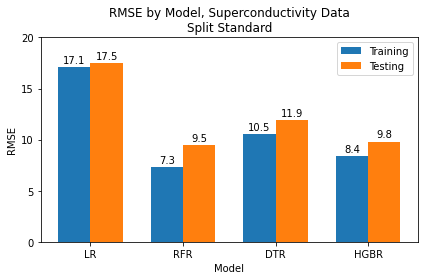

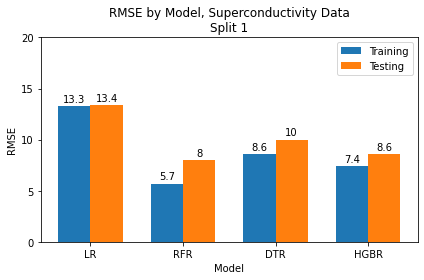

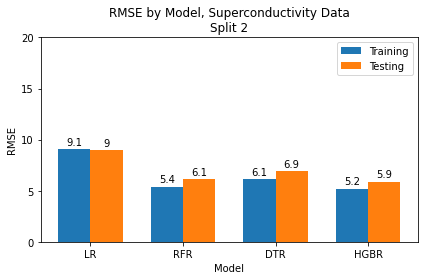

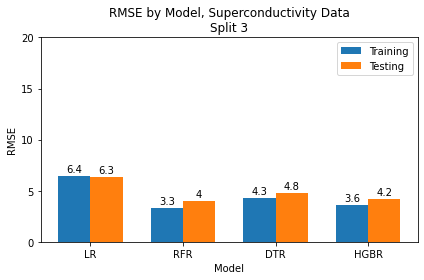

In [72]:
# plot RMSE of predictions on train and test

plot_rmse_train_test(rmse_0, 'Standard')
plot_rmse_train_test(rmse_1, 1)
plot_rmse_train_test(rmse_2, 2)
plot_rmse_train_test(rmse_3, 3)

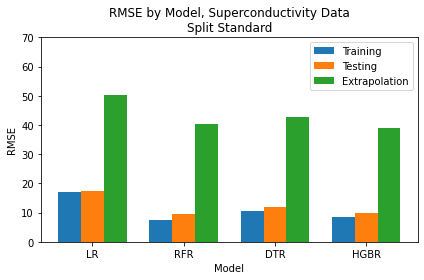

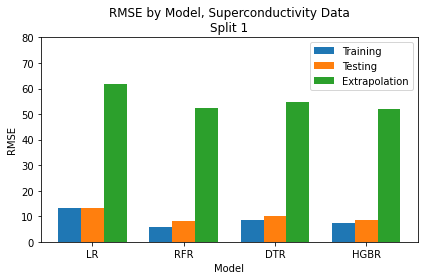

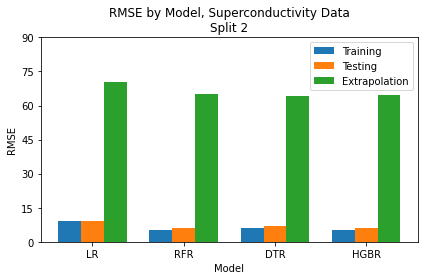

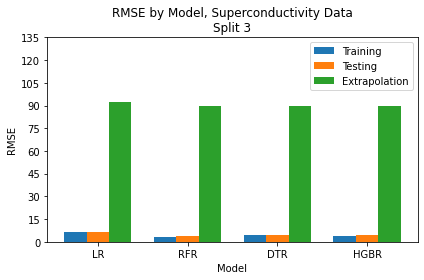

In [81]:
# plot RMSE of predictions on train, test, and extrapolation

plot_rmse_train_test_extrap(rmse_0, 'Standard', np.arange(0,75,10))
plot_rmse_train_test_extrap(rmse_1, 1, np.arange(0,81,10))
plot_rmse_train_test_extrap(rmse_2, 2, np.arange(0,96,15))
plot_rmse_train_test_extrap(rmse_3, 3, np.arange(0,136,15))

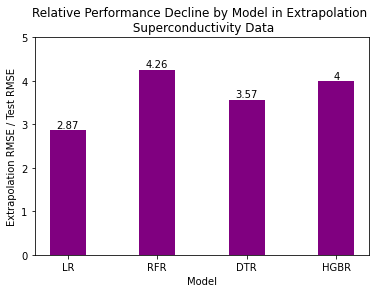

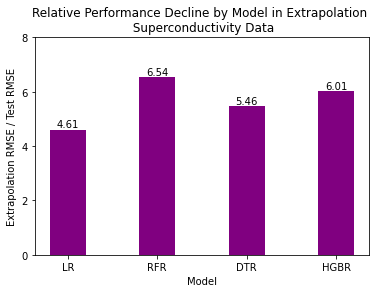

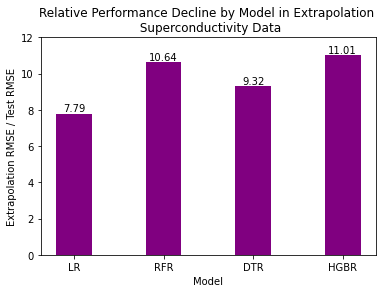

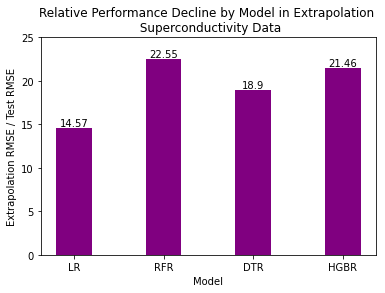

In [85]:
# plot relative difference of RMSE between extrapolation and test

plot_relative_perf(rmse_0, 'Superconductivity Data', np.arange(0,6,1))
plot_relative_perf(rmse_1, 'Superconductivity Data', np.arange(0,10,2))
plot_relative_perf(rmse_2, 'Superconductivity Data', np.arange(0,14,2))
plot_relative_perf(rmse_3, 'Superconductivity Data', np.arange(0,30,5))

In [75]:
print('DONE!')

DONE!


# Spare code